In [15]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from powerLaw_exponent import powerLaw_exponent
from KH_model import KH_model
from synthetic_powerLaw import synthetic_powerLaw

#parameters-change these as needed
#n--num of nodes in the graph
#m--num of edges need to be add by each arriving node
n = 500
m = 3
m_t = 0.3

In [4]:
import itertools
import math
from collections import defaultdict

import networkx as nx
from networkx.utils import py_random_state

# The following function is our modified Holme-Kim Model based on source code from networkx
def degree_HK(n, m, p, seed=None):
   
    if m < 1 or n < m:
        raise nx.NetworkXError(f"NetworkXError must have m>1 and m<n, m={m},n={n}")

    if p > 1 or p < 0:
        raise nx.NetworkXError(f"NetworkXError p must be in [0,1], p={p}")

    # Modification 1:
    # Start the algorithm with an initial random graph with m nodes and m edges to allow different values of m
    G = nx.gnm_random_graph(m, m)
    repeated_nodes = list(G.nodes())  # list of existing nodes to sample from
    # with nodes repeated once for each adjacent edge
    source = m  # next node is m
    while source < n:  # Now add the other n-1 nodes
        possible_targets = list(np.random.choice(repeated_nodes, m, replace = False))
        # do one preferential attachment for new node
        target = possible_targets.pop()
        G.add_edge(source, target)
        repeated_nodes.append(target)  # add one node to list for each new link
        count = 1
        while count < m:  # add m-1 more new links
            if random.uniform(0, 1) < p:  # clustering step: add triangle
                neighborhood = [
                    nbr
                    for nbr in G.neighbors(target)
                    if not G.has_edge(source, nbr) and not nbr == source
                ]
                # Modification 2:
                # In the TF step, if there is a neighbor without a link, instead of randomly choose a node, choose a neighbor weighted by its degree
                if neighborhood:  
                    repeated = []
                    for neighbor in neighborhood:
                        d = G.degree(neighbor)
                        repeated.extend([neighbor]*d)
                    nbr = random.choice(repeated)
                    repeated_nodes.append(nbr)
                    G.add_edge(source, nbr)
                    count = count + 1
                    continue  # go to top of while loop
            # else do preferential attachment step if above fails
            target = possible_targets.pop()
            G.add_edge(source, target)
            repeated_nodes.append(target)
            count = count + 1

        repeated_nodes.extend([source] * m)  # add source node to list m times
        source += 1
    return G

In [5]:
def neighborhood_overlap(G,u,v):
    c_uv = len(list(nx.common_neighbors(G,u,v)))
    total = (G.degree(u)+G.degree(v)-2-c_uv)
    score =c_uv/total
    # print(score)
    return score

In [6]:
from collections import Counter
import bisect

my_nums = {'A': 5, 'B': 2, 'C': 2, 'D': 1}

def weighted_random(weighted_dict):
    # print(weighted_dict)
    weight_sum = []
    sum = 0
    for w in weighted_dict.values():
        sum += w
        weight_sum.append(sum)
    # r = random.uniform(0, sum)
    r = random.random()*sum
    idx = bisect.bisect_right(weight_sum, r)
    # print(r,idx)
    return list(weighted_dict.keys())[idx-1]


In [7]:
# The following function is our modified Holme-Kim Model based on source code from networkx
def overlap_HK(n, m, p, seed=None):

    if m < 1 or n < m:
        raise nx.NetworkXError(f"NetworkXError must have m>1 and m<n, m={m},n={n}")

    if p > 1 or p < 0:
        raise nx.NetworkXError(f"NetworkXError p must be in [0,1], p={p}")

    # Modification 1:
    # Start the algorithm with an initial random graph with m nodes and m edges to allow different values of m
    G = nx.gnm_random_graph(m, m)
    print(G)
    repeated_nodes = list(G.nodes())  # list of existing nodes to sample from
    # with nodes repeated once for each adjacent edge
    source = m  # next node is m
    while source < n:  # Now add the other n-1 nodes
        possible_targets = list(np.random.choice(repeated_nodes, m, replace = False))
        # do one preferential attachment for new node
        target = possible_targets.pop()
        G.add_edge(source, target)
        repeated_nodes.append(target)  # add one node to list for each new link
        count = 1
        while count < m:  # add m-1 more new links
            if random.uniform(0, 1) < p:  # clustering step: add triangle
                neighborhood = [
                    nbr
                    for nbr in G.neighbors(target)
                    if not G.has_edge(source, nbr) and not nbr == source
                ]
                # Modification 2:
                # In the TF step, if there is a neighbor without a link, instead of randomly choose a node, choose a neighbor weighted by neighborhood overlap
                if neighborhood:
                    overlap_dict = {}
                    for neighbor in neighborhood:
                        #compute the neighborhood overlap score and store it in the dictionary
                        overlap_dict[neighbor] = neighborhood_overlap(G,target,neighbor)
                    
                    overlap_dict=dict(sorted(overlap_dict.items(), key=lambda item: item[1]))
                    nbr = weighted_random(overlap_dict)
                    repeated_nodes.append(nbr)
                    G.add_edge(source, nbr)
                    count = count + 1
                    continue  # go to top of while loop
            # else do preferential attachment step if above fails
            target = possible_targets.pop()
            G.add_edge(source, target)
            repeated_nodes.append(target)
            count = count + 1

        repeated_nodes.extend([source] * m)  # add source node to list m times
        source += 1
    return G

In [8]:
### This cell is for comparing different statistics with various P_t and N
m_t = [0,0.3,0.6,0.9,1.2,1.5,1.8]
P_t = [p/2 for p in m_t]
N = [100,200,500,1000,2000,4000,6000,8000,10000]

cc_hk=[]
cc_degree=[]
cc_overlap = []

for p in P_t:
    hk=[]
    degree=[]
    overlap=[]
    for n in N:
        G1 = nx.powerlaw_cluster_graph(n, m, p)
        G2 = degree_HK(n, m, p)
        G3 = overlap_HK(n,m,p)
        hk.append(nx.average_clustering(G1))
        degree.append(nx.average_clustering(G2))
        overlap.append(nx.average_clustering(G3))
    cc_hk.append(hk)
    cc_degree.append(degree)
    cc_overlap.append(overlap)

Graph with 3 nodes and 3 edges
Graph with 3 nodes and 3 edges
Graph with 3 nodes and 3 edges
Graph with 3 nodes and 3 edges
Graph with 3 nodes and 3 edges
Graph with 3 nodes and 3 edges
Graph with 3 nodes and 3 edges
Graph with 3 nodes and 3 edges
Graph with 3 nodes and 3 edges
Graph with 3 nodes and 3 edges
Graph with 3 nodes and 3 edges
Graph with 3 nodes and 3 edges
Graph with 3 nodes and 3 edges
Graph with 3 nodes and 3 edges
Graph with 3 nodes and 3 edges
Graph with 3 nodes and 3 edges
Graph with 3 nodes and 3 edges
Graph with 3 nodes and 3 edges
Graph with 3 nodes and 3 edges
Graph with 3 nodes and 3 edges
Graph with 3 nodes and 3 edges
Graph with 3 nodes and 3 edges
Graph with 3 nodes and 3 edges
Graph with 3 nodes and 3 edges
Graph with 3 nodes and 3 edges
Graph with 3 nodes and 3 edges
Graph with 3 nodes and 3 edges
Graph with 3 nodes and 3 edges
Graph with 3 nodes and 3 edges
Graph with 3 nodes and 3 edges
Graph with 3 nodes and 3 edges
Graph with 3 nodes and 3 edges
Graph wi

Text(0, 0.5, 'Clustering Coefficient')

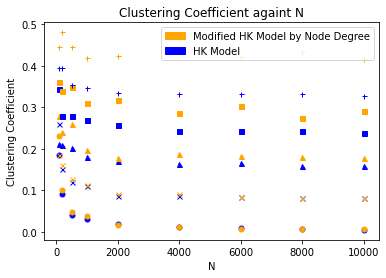

In [18]:
plt.plot(N, cc_hk[0], 'o', color = 'blue', markersize = 5)
plt.plot(N, cc_degree[0], 'o', color = 'orange', markersize = 5)
# plt.plot(N, cc_overlap[0], 'o', color = 'green', markersize = 5)

plt.plot(N, cc_hk[1], 'x', color = 'blue' , markersize = 5)
plt.plot(N, cc_degree[1], 'x', color = 'orange', markersize = 5)
# plt.plot(N, cc_overlap[1], 'x', color = 'green', markersize = 5)

plt.plot(N, cc_hk[2], '^', color = 'blue' , markersize = 5)
plt.plot(N, cc_degree[2], '^', color = 'orange', markersize = 5)
# plt.plot(N, cc_overlap[2], '^', color = 'green', markersize = 5)

plt.plot(N, cc_hk[3], 's', color = 'blue' , markersize = 5)
plt.plot(N, cc_degree[3], 's', color = 'orange', markersize = 5)
# plt.plot(N, cc_overlap[3], 's', color = 'green', markersize = 5)

plt.plot(N, cc_hk[4], '+', color = 'blue' , markersize = 5)
plt.plot(N, cc_degree[4], '+', color = 'orange', markersize = 5)
# plt.plot(N, cc_overlap[4], '+', color = 'green', markersize = 5)

# plt.legend(loc='upper left')
orange_patch = mpatches.Patch(color='orange', label='Modified HK Model by Node Degree')
blue_patch = mpatches.Patch(color='blue', label='HK Model')
plt.legend(handles=[orange_patch,blue_patch])
plt.title("Clustering Coefficient againt N", loc="center")
plt.xlabel("N")
plt.ylabel("Clustering Coefficient")

Text(0, 0.5, 'Clustering Coefficient')

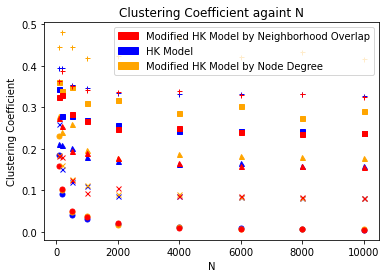

In [37]:
plt.plot(N, cc_hk[0], 'o', color = 'blue', markersize = 5)
plt.plot(N, cc_degree[0], 'o', color = 'orange', markersize = 5)
plt.plot(N, cc_overlap[0], 'o', color = 'red', markersize = 5)

plt.plot(N, cc_hk[1], 'x', color = 'blue' , markersize = 5)
plt.plot(N, cc_degree[1], 'x', color = 'orange', markersize = 5)
plt.plot(N, cc_overlap[1], 'x', color = 'red', markersize = 5)

plt.plot(N, cc_hk[2], '^', color = 'blue' , markersize = 5)
plt.plot(N, cc_degree[2], '^', color = 'orange', markersize = 5)
plt.plot(N, cc_overlap[2], '^', color = 'red', markersize = 5)

plt.plot(N, cc_hk[3], 's', color = 'blue' , markersize = 5)
plt.plot(N, cc_degree[3], 's', color = 'orange', markersize = 5)
plt.plot(N, cc_overlap[3], 's', color = 'red', markersize = 5)

plt.plot(N, cc_hk[4], '+', color = 'blue' , markersize = 5)
plt.plot(N, cc_degree[4], '+', color = 'orange', markersize = 5)
plt.plot(N, cc_overlap[4], '+', color = 'red', markersize = 5)
# plt.legend(loc='upper left')

red_patch = mpatches.Patch(color='red', label='Modified HK Model by Neighborhood Overlap')
blue_patch = mpatches.Patch(color='blue', label='HK Model')
orange_patch = mpatches.Patch(color='orange', label='Modified HK Model by Node Degree')

plt.legend(handles=[red_patch,blue_patch,orange_patch])
plt.title("Clustering Coefficient againt N", loc="center")
plt.xlabel("N")
plt.ylabel("Clustering Coefficient")

[0.01902304 0.08655779 0.17138866 0.25782134 0.33458087 0.42806914
 0.51464509]
[0.01708212 0.09045886 0.17712407 0.31796742 0.42362932 0.55336183
 0.69765515]
[0.02092031 0.10625607 0.17728298 0.247494   0.33789601 0.42391124
 0.54077207]


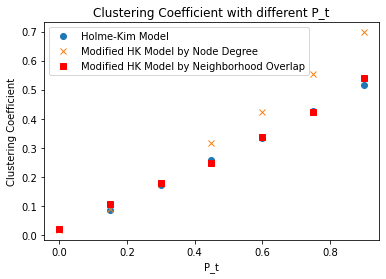

In [38]:
# plot cc against p_t 
# we use n=4000,m=3 to check the relationship
plt.plot(P_t, np.array(cc_hk)[:,4], 'o', label='Holme-Kim Model' )
plt.plot(P_t, np.array(cc_degree)[:,4], 'x', label='Modified HK Model by Node Degree' )
plt.plot(P_t, np.array(cc_overlap)[:,4], 's', color = 'red',label='Modified HK Model by Neighborhood Overlap' )
# ax = plt.gca()
# ax.set_xscale('log')
# ax.set_yscale('log')

plt.legend(loc='upper left')
plt.title("Clustering Coefficient with different P_t", loc="center")
plt.xlabel("P_t")
plt.ylabel("Clustering Coefficient")

print(np.array(cc_hk)[:,4])
print(np.array(cc_degree)[:,4])
print(np.array(cc_overlap)[:,4])

In [41]:
#save Graph of each model, n=400,m=3,p=.6
G1 = nx.powerlaw_cluster_graph(100, 3, 0.6)
G2 = degree_HK(100, 3, 0.6)
G3 = overlap_HK(100, 3, 0.6)
nx.write_gexf(G1,"HK1.gexf")
nx.write_gexf(G2,"HK_degree1.gexf")
nx.write_gexf(G3,"HK_neighbor1.gexf")

Graph with 3 nodes and 3 edges


In [36]:
### estimate alpha using the above graphs
alpha_hk=[]
alpha_degree=[]
alpha_overlap=[]

for i in range(5):#repeat 5 times, calculate mean of extimated alpha
    G1 = nx.powerlaw_cluster_graph(4000, 3, 0.6)
    G2 = degree_HK(4000, 3, 0.6)
    G3 = overlap_HK(4000, 3, 0.6)
    G_BA = nx.barabasi_albert_graph(4000, 3)
    
    degrees1 = list()
    for d in G1.degree():
        degrees1.append(d[1])
    alpha_hk.append(powerLaw_exponent(degrees1, kmin=1))
    
    degrees2 = list()
    for d in G2.degree():
        degrees2.append(d[1])
    alpha_degree.append(powerLaw_exponent(degrees2, kmin=1))
    
    degrees3 = list()
    for d in G3.degree():
        degrees3.append(d[1])
    alpha_overlap.append(powerLaw_exponent(degrees3, kmin=1))
print(sum(alpha_hk)/5)
print(sum(alpha_degree)/5)
print(sum(alpha_overlap)/5)

Graph with 3 nodes and 3 edges
Graph with 3 nodes and 3 edges
Graph with 3 nodes and 3 edges
Graph with 3 nodes and 3 edges
Graph with 3 nodes and 3 edges
Graph with 3 nodes and 3 edges
2.7270963817133698
2.2832185683457698
2.7433048223482532


Graph with 3 nodes and 3 edges


Text(0, 0.5, 'Frequency')

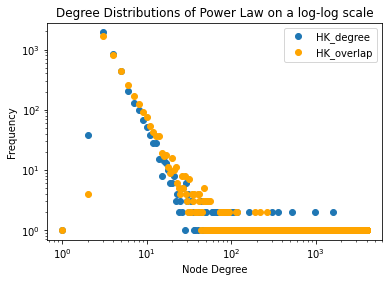

In [43]:
G_test = degree_HK(4000, 3, 0.6)
G_test2 = overlap_HK(4000, 3, 0.6)
degrees = list(G_test.degree())
degrees2 = list(G_test2.degree())
d,counts = np.unique(degrees, return_counts = True)
d2,counts2 = np.unique(degrees2, return_counts = True)

# plot degrees against their proportions in the dataset
plt.plot(d,counts, 'o', label='HK_degree' )
plt.plot(d2,counts2, 'o',color = "orange", label='HK_overlap' )
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

plt.legend(loc='upper right')
plt.title("Degree Distributions of Power Law on a log-log scale", loc="center")
plt.xlabel("Node Degree")
plt.ylabel("Frequency")

In [120]:
kmin=1
degrees = list()
for d in G_test.degree():
    degrees.append(d[1])
# print(degrees)
samples_set = list(set(degrees))
samples_set.sort()

samples_freq = [degrees.count(sample)  for sample in samples_set]
samples_proportion = [degrees.count(sample) / len(degrees) for sample in samples_set]

# # Calculate y = log(P(X >= k))
# proportions = (counts/10000).tolist()
# kmin=1

culmulative_density = samples_proportion[:] # copy by value, not reference
culmulative_density.reverse()

import itertools
culmulative_density = list(itertools.accumulate(culmulative_density))
culmulative_density.reverse()

culmulative_density = np.log(culmulative_density)

# Find x = log(k / kmin)
X = np.ones((len(samples_set), 2))
for i in range(len(samples_set)):
    X[i][0] = np.log(samples_set[i] / kmin)

# solve least square problem
m, c = np.linalg.lstsq(X, culmulative_density)[0]

# report statistics
print("alpha = 1 - m is: " + str(1-m))

alpha = 1 - m is: 2.707863531156507


/var/folders/4t/yyym5sgn6lxbt5mmh_67x2tw0000gn/T/ipykernel_71560/329576348.py:31: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(X, culmulative_density)[0]
